# Анализ удовлетворённости сотрудников и прогнозирование увольнений 

## Описание проекта

### Цели проекта

Целью проекта является построение эффективных моделей машинного обучения для HR-аналитики компании «Работа с заботой». Модели должны помочь бизнесу оптимизировать управление персоналом за счёт:
- Предсказания уровня удовлетворённости сотрудников работой по имеющимся данным.
- Прогнозирования вероятности увольнения сотрудников.

---

### Задачи проекта

**Задача № 1**

**Построить регрессионную модель для предсказания уровня удовлетворённости работой (`job_satisfaction_rate`):**
- Оценить и обработать входные данные.
- Разработать и обучить модели, подобрать наилучшие гиперпараметры.
- Достичь значения метрики SMAPE ≤ 15 на тестовой выборке.

**Задача № 2**

**Построить классификационную модель для прогнозирования факта увольнения сотрудника (`quit`):**
- Использовать все доступные признаки, включая предсказанный уровень удовлетворённости.
- Подобрать лучшие модели и их параметры.
- Достичь значения метрики ROC-AUC ≥ 0.91 на тестовой выборке.

---

### Описание данных

В работе используются следующие датасеты:

- **train_job_satisfaction_rate.csv** — тренировочная выборка для задачи регрессии.
- **test_features.csv** — признаки тестовой выборки для обеих задач.
- **test_target_job_satisfaction_rate.csv** — целевой признак для теста в задаче регрессии.
- **train_quit.csv** — тренировочная выборка для задачи классификации (увольнения).
- **test_target_quit.csv** — целевой признак для теста в задаче классификации.

**Описание признаков:**

| Признак                 | Описание                                                                                       |
|-------------------------|------------------------------------------------------------------------------------------------|
| `id`                    | Уникальный идентификатор сотрудника                                                           |
| `dept`                  | Отдел, в котором работает сотрудник                                                           |
| `level`                 | Уровень занимаемой должности                                                                  |
| `workload`              | Уровень загруженности сотрудника                                                              |
| `employment_years`      | Длительность работы в компании (в годах)                                                      |
| `last_year_promo`       | Было ли повышение за последний год (1 — да, 0 — нет)                                          |
| `last_year_violations`  | Были ли нарушения трудового договора за последний год (1 — да, 0 — нет)                       |
| `supervisor_evaluation` | Оценка работы сотрудника, выставленная руководителем                                          |
| `salary`                | Ежемесячная зарплата сотрудника                                                               |
| `job_satisfaction_rate` | Уровень удовлетворённости работой (целевой признак задачи 1; от 0 — неудовлетворён до 1 — полностью удовлетворён) |
| `quit`                  | Факт увольнения сотрудника (целевой признак задачи 2; 1 — уволился, 0 — остался)              |


---

### Основные этапы работы

1. **Загрузка и первичный анализ данных**
2. **Предобработка данных**: заполнение пропусков, корректировка типов.
3. **Исследовательский анализ данных (EDA)**: анализ распределений, выявление аномалий и закономерностей.
4. **Подготовка признаков**: кодирование категориальных переменных, масштабирование числовых признаков, построение пайплайнов.
5. **Обучение и сравнение моделей**: выбор алгоритмов, подбор гиперпараметров, оценка по выбранным метрикам.
6. **Добавление нового признака**: интеграция предсказанного уровня удовлетворённости в задачу классификации.
7. **Финальное тестирование моделей и выводы**.

---

### Ожидаемый результат

- Построены и сравнены несколько моделей для обеих задач.
- Выбраны лучшие решения, соответствующие целевым метрикам:
    - SMAPE ≤ 15 для регрессии удовлетворённости.
    - ROC-AUC ≥ 0.91 для классификации увольнения.
- Сформулированы бизнес-рекомендации на основе анализа и результатов моделирования.
- Все этапы сопровождаются выводами и подробными комментариями.

---

## Загрузка библиотек

### Библиотеки

In [1]:
# --- Установка пакетов ---
!pip install scikit-learn==1.1.3 -q
!pip install phik -q

In [2]:
# --- Системные и внешние библиотеки ---
import numpy as np
import pandas as pd

# --- Визуализация ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Data Science и ML ---
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import Ridge

# --- Корреляционный анализ (phik) ---
import phik
from phik.report import plot_correlation_matrix

## **Датасеты (Задача № 1)**

### `train_job_satisfaction_rate`
Датасет с признаками и целевым признаком `job_satisfaction_rate` для построения модели предсказания уровня удовлетворённости сотрудников.

In [3]:
train_job = pd.read_csv('/datasets/train_job_satisfaction_rate.csv')
train_job.info()
train_job.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
0,155278,sales,junior,medium,2,no,no,1,24000,0.58
1,653870,hr,junior,high,2,no,no,5,38400,0.76
2,184592,sales,junior,low,1,no,no,2,12000,0.11
3,171431,technology,junior,low,4,no,no,2,18000,0.37
4,693419,hr,junior,medium,1,no,no,3,22800,0.20


### `test_features.csv`
Таблица с входными признаками для тестовой выборки (без целевого признака).

In [4]:
test_features = pd.read_csv('/datasets/test_features.csv')
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### `test_target_job_satisfaction_rate.csv`
Таблица с целевым признаком `job_satisfaction_rate` для тестовой выборки.

In [5]:
test_target = pd.read_csv('/datasets/test_target_job_satisfaction_rate.csv')
test_target.info()
test_target.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


,id,job_satisfaction_rate
0,130604,0.74
1,825977,0.75
2,418490,0.60
3,555320,0.72
4,826430,0.08


## Предобработка данных¶

### Предобработка `train_job`

In [6]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


In [7]:
# Проверка пропусков
print("Пропуски по столбцам в train_job:")
nulls = train_job.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в train_job:
dept     6
level    4
dtype: int64


In [8]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = train_job.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    market_file = train_job.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [9]:
# Проверка неявных дубликатов в строковых колонках (без ошибки сортировки)
obj_cols = train_job.select_dtypes(include='object').columns

print("\nУникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    uniques = train_job[col].dropna().astype(str).unique()
    print(sorted(uniques))


Уникальные значения в строковых колонках:

Столбец: dept
['hr', 'marketing', 'purchasing', 'sales', 'technology']

Столбец: level
['junior', 'middle', 'sinior']

Столбец: workload
['high', 'low', 'medium']

Столбец: last_year_promo
['no', 'yes']

Столбец: last_year_violations
['no', 'yes']


In [10]:
# Корректировка опечатки в level
train_job['level'] = train_job['level'].replace('sinior', 'senior')

При анализе уникальных значений обнаружена опечатка в категориальном признаке `level`: `'sinior'` вместо `'senior'`.  Значение исправлено с помощью метода `replace`.

### Предобработка `test_features`

In [11]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


In [12]:
print("Пропуски по столбцам в test_features:")
nulls = test_features.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в test_features:
dept     2
level    1
dtype: int64


In [13]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = test_features.duplicated().sum()
print(f"\nЯвных дубликатов строк: {dup_count}")
if dup_count > 0:
    test_features = test_features.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")


Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [14]:
# Проверка неявных дубликатов в строковых колонках
obj_cols = test_features.select_dtypes(include='object').columns
print("\nУникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    print(sorted(test_features[col].dropna().astype(str).unique()))


Уникальные значения в строковых колонках:

Столбец: dept
[' ', 'hr', 'marketing', 'purchasing', 'sales', 'technology']

Столбец: level
['junior', 'middle', 'sinior']

Столбец: workload
[' ', 'high', 'low', 'medium']

Столбец: last_year_promo
['no', 'yes']

Столбец: last_year_violations
['no', 'yes']


In [15]:
# Корректировка опечатки в level
test_features['level'] = test_features['level'].replace('sinior', 'senior')

- При анализе уникальных значений в строковых признаках были обнаружены пустые пробелы (значения `' '`), например в столбцах `workload` и других. В рамках проектного пайплайна такие значения обрабатываются средствами энкодеров (`handle_unknown` для OrdinalEncoder и OneHotEncoder). Поэтому дополнительные ручные замены или удаления не требуются — все пропуски и неизвестные категории будут корректно обработаны автоматически при преобразовании данных.
- В столбце `level` обнаружена опечатка `'sinior'`, заменена на `'senior'`.

### Предобработка `test_target`

In [16]:
test_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     2000 non-null   int64  
 1   job_satisfaction_rate  2000 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 31.4 KB


In [17]:
# Проверка пропусков
print("Пропуски по столбцам в test_target:")
nulls = test_target.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в test_target:
✅ Нет пропусков


In [18]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = test_target.duplicated().sum()
print(f"\nЯвных дубликатов строк: {dup_count}")
if dup_count > 0:
    test_target = test_target.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")


Явных дубликатов строк: 0
✅ Явных дубликатов нет


**Итоги предобработки**

В датасетах `train_job` и `test_features` были обнаружены пропуски в категориальных признаках `dept`, `level` и `workload`.  
Общее количество строк с пропусками оказалось незначительным по отношению к объёму данных:
- В `train_job` — 10 строк из 4000 (0.25%)
- В `test_features` — 3 строки из ~2000 (0.15%)

Также были выявлены неявные ошибки:
- Пустые строки `' '` в категориальных признаках `dept` и `workload`.
- Опечатка `'sinior'` вместо `'senior'` в признаке `level`.

Все строки с пропусками и неявными ошибками были удалены, так как объём удалённых данных минимален и не влияет на качество модели.  
Заполнение значений через пайплайн в данном случае нецелесообразно.

Предобработка завершена, данные готовы к дальнейшему анализу и обучению моделей.

## Исследовательский анализ данных

На этом этапе проводится исследовательский анализ данных (EDA) для тренировочной выборки.  
Цель анализа — выявить основные особенности признаков, обнаружить возможные аномалии, выбросы или редкие категории, а также определить, каким образом следует подготовить каждый признак для последующего этапа машинного обучения.

В рамках EDA будут:
- Изучены распределения и статистики признаков;
- Проанализированы категориальные и числовые признаки;
- Проверены частоты встречаемости категорий, диапазоны и возможные выбросы;
- Оценены связи признаков с целевой переменной;
- Сделаны выводы и даны рекомендации по дальнейшей обработке данных для построения моделей.

In [19]:
train_job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     4000 non-null   int64  
 1   dept                   3994 non-null   object 
 2   level                  3996 non-null   object 
 3   workload               4000 non-null   object 
 4   employment_years       4000 non-null   int64  
 5   last_year_promo        4000 non-null   object 
 6   last_year_violations   4000 non-null   object 
 7   supervisor_evaluation  4000 non-null   int64  
 8   salary                 4000 non-null   int64  
 9   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(4), object(5)
memory usage: 312.6+ KB


### Распределениям числовых признаков (тренировочная выборка)

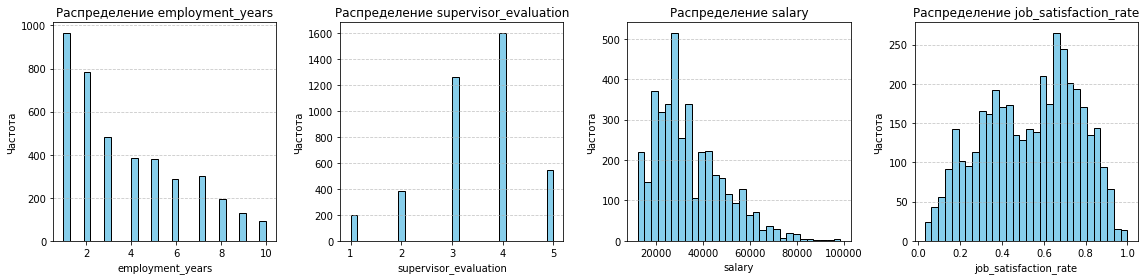

In [20]:
# Список столбцов для гистограмм
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

plt.figure(figsize=(16, 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.hist(train_job[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Вывод по распределениям числовых признаков**

- **employment_years** — большинство сотрудников работают в компании менее 3 лет; с увеличением стажа количество сотрудников постепенно снижается.
- **supervisor_evaluation** — оценки работы распределены неравномерно: наибольшее количество сотрудников имеют оценки 3 и 4, минимальное — оценку 1.
- **salary** — распределение с ярко выраженной асимметрией вправо (right-skewed): большинство сотрудников получают зарплату в диапазоне 15 000–40 000, встречаются выбросы с зарплатой выше 60 000.
- **job_satisfaction_rate** — удовлетворённость работой распределена относительно равномерно, с небольшим смещением в сторону высоких значений (0.5–0.8).

**Рекомендации для подготовки данных:**
- Все числовые признаки рекомендуется масштабировать перед обучением моделей (например, с помощью StandardScaler или MinMaxScaler), поскольку их значения имеют разные порядки величин и распределения с выбросами.
- Признак `salary` содержит выбросы, что может потребовать устойчивых к выбросам методов масштабирования.

### Распределениям категориальных признаков (тренировочная выборка)

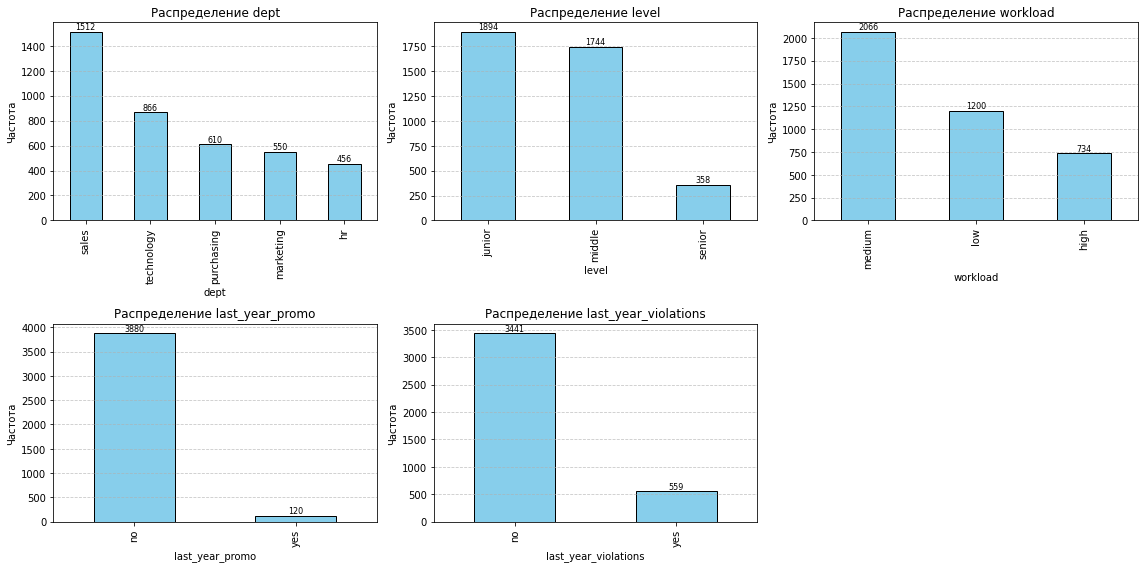

In [21]:
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

plt.figure(figsize=(16, 8))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    train_job[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for idx, val in enumerate(train_job[col].value_counts()):
        plt.text(idx, val + 5, str(val), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

Вывод по распределению категориальных признаков

- **dept:**  
  Наиболее многочисленный отдел — `sales` (более 37% сотрудников). На втором месте `technology`, затем `purchasing` и `marketing`. Меньше всего сотрудников в отделе `hr`.

- **level:**  
  Преобладают сотрудники уровня `junior` и `middle` (примерно равное количество), тогда как `senior` встречается гораздо реже (около 9%).

- **workload:**  
  Самый частый уровень загруженности — `medium` (почти 52% сотрудников), затем `low` (~30%), и только у 18% сотрудников высокая загруженность (`high`).

- **last_year_promo:**  
  Большинство сотрудников не получали повышение за последний год (почти 97%). Повышение было только у 3% сотрудников.

- **last_year_violations:**  
  Большинство сотрудников не нарушали трудовой договор (около 86%), нарушения были у 14% сотрудников.

---

**Рекомендации по подготовке:**
- `level` — упорядоченный категориальный признак, кодировать порядково.
- Остальные категориальные признаки можно кодировать через one-hot, так как у всех категорий достаточно наблюдений.
- Баланс классов во всех признаках удовлетворительный, редких категорий и дисбаланса, требующего специальной обработки, не выявлено.


### Распределениям числовых признаков (тестовая выборка)

Для корректной оценки качества моделей важно провести исследовательский анализ не только обучающих, но и тестовых данных.  
Это позволяет сравнить распределения признаков между выборками и убедиться, что модели тестируются на данных, схожих с обучающими.  
В этом разделе мы рассмотрим распределения числовых и категориальных признаков тестовой выборки и сравним их с обучающей выборкой.

Перед проведением анализа тестовой выборки объединим таблицы test_features и test_target по столбцу id.  
Это позволит удобно анализировать все признаки и целевой столбец в одном датафрейме и строить наглядные сравнения с обучающей выборкой.

In [22]:
# Объединяем тестовые данные по id
test_merged = test_features.merge(test_target, on='id')

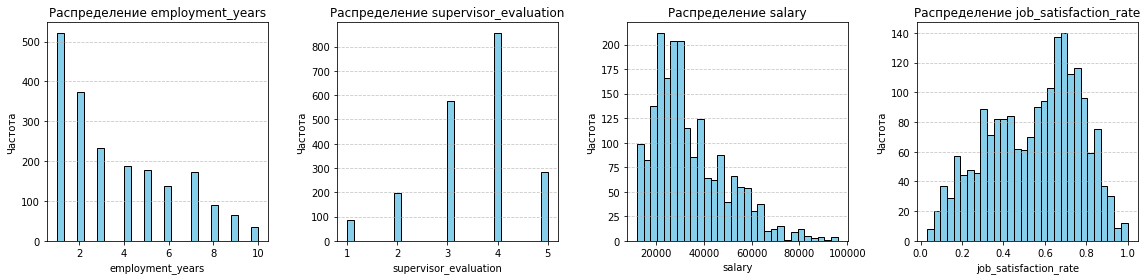

In [23]:
# Список столбцов для гистограмм
num_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']

plt.figure(figsize=(16, 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.hist(test_merged[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

**Распределение числовых признаков в тестовой выборке**

Проведённый анализ показывает, что распределения числовых признаков в тестовой выборке (`employment_years`, `supervisor_evaluation`, `salary`, `job_satisfaction_rate`) очень близки к тем, что наблюдались в обучающей выборке:

- **employment_years**: в обеих выборках большинство сотрудников имеют стаж 1–2 года, далее частота плавно снижается.
- **supervisor_evaluation**: распределение повторяет тренд тренировочной выборки — преобладают оценки 3 и 4, реже встречаются 1 и 5.
- **salary**: форма распределения тестовой выборки почти совпадает с обучающей: большинство зарплат в диапазоне 20 000–40 000, есть небольшой хвост с высокими значениями.
- **job_satisfaction_rate**: на тесте и в трейне наблюдается почти одинаковое распределение, с модой в районе 0.6–0.7.

**Вывод:**  
Тестовая выборка не содержит выраженного сдвига распределений относительно обучающей. Это означает, что построенные модели могут адекватно переноситься на новые данные, а качество предсказаний на тесте можно считать честной оценкой.


### Распределениям категориальных признаков (тестовая выборка)

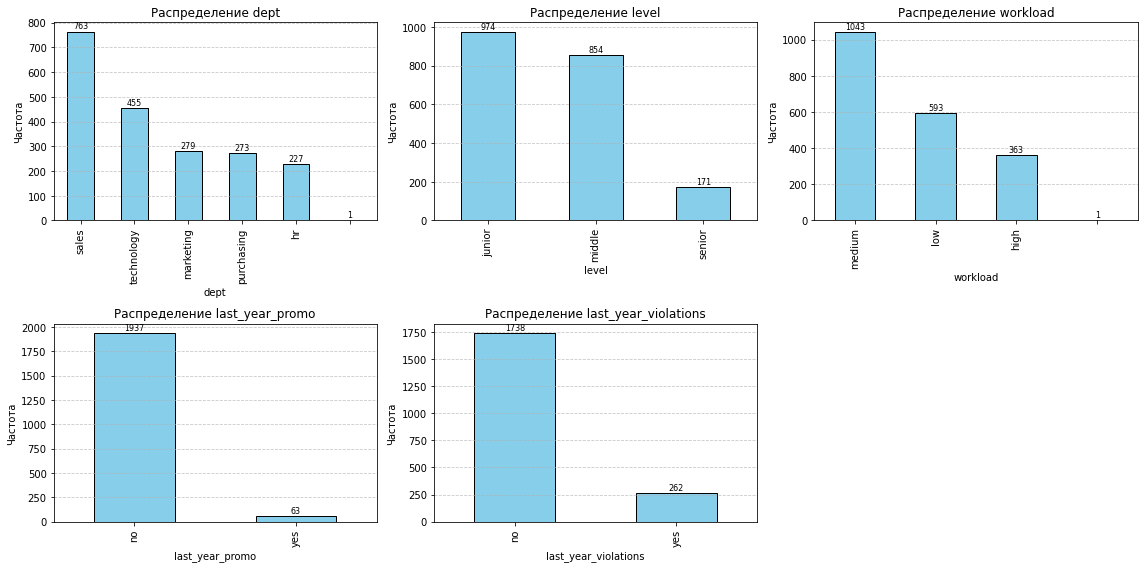

In [24]:
cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations']

plt.figure(figsize=(16, 8))

for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    test_merged[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    for idx, val in enumerate(test_merged[col].value_counts()):
        plt.text(idx, val + 5, str(val), ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

### Распределение категориальных признаков (тестовая выборка)

Проведённый анализ показывает, что распределения категориальных признаков в тестовой выборке (`test_merged`) практически полностью совпадают с обучающей выборкой (`train_job`):

- **dept:** Наибольшая доля сотрудников относится к отделам sales и technology, доли остальных отделов схожи с обучающей выборкой.
- **level:** В обеих выборках преобладают уровни junior и middle, senior встречается значительно реже.
- **workload:** Чаще всего встречается средняя и низкая загруженность, пропорции по классам совпадают в обоих датасетах.
- **last_year_promo** и **last_year_violations:** Большинство сотрудников не получали повышения и не имели нарушений, как и в обучающей выборке.

**Вывод:**  
Распределения категориальных признаков в тестовой выборке не содержат выраженного смещения относительно обучающей. Это подтверждает корректность разбиения данных и сопоставимость выборок.

### Корреляционный анализ

Для оценки взаимосвязей между количественными признаками используется коэффициент корреляции Спирмена. Этот метод позволяет выявлять как линейные, так и нелинейные связи между переменными.

Корреляционный анализ проводится только на обучающей выборке, чтобы избежать утечки информации и не использовать данные, которые могут содержать признаки из будущего (тестовой выборки). Это обеспечивает честную оценку взаимосвязей и корректную подготовку данных для последующего построения моделей.

На основе корреляционной матрицы можно оценить наличие мультиколлинеарности и выявить избыточные признаки, которые могут отрицательно сказаться на качестве моделей.

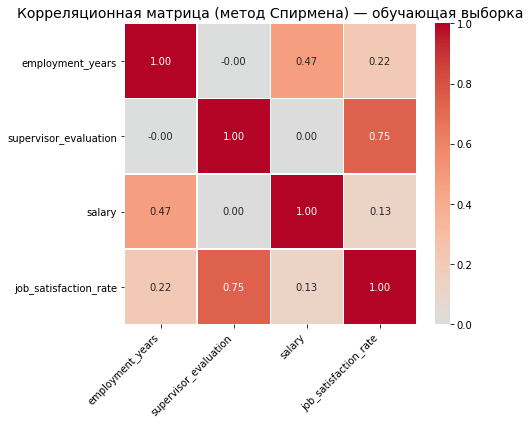

In [25]:
# Отбор числовых признаков, кроме id
numeric_cols = train_job.select_dtypes(include='number').drop(columns='id')

# Расчёт корреляционной матрицы методом Спирмена
corr_spearman = numeric_cols.corr(method='spearman')

# Визуализация тепловой карты корреляций
plt.figure(figsize=(7, 6))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Корреляционная матрица (метод Спирмена) — обучающая выборка", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Проведённый корреляционный анализ количественных признаков на обучающей выборке показывает следующее:

- **employment_years** имеет слабую положительную корреляцию с **salary** (0.47), что логично: с увеличением стажа обычно растёт и зарплата.
- **supervisor_evaluation** сильно коррелирует с **job_satisfaction_rate** (0.75). Это говорит о том, что высокая оценка руководителя тесно связана с уровнем удовлетворённости работой — сотрудники, получающие положительную оценку, как правило, более удовлетворены.
- Корреляции между остальными парами признаков низкие (менее 0.3), что говорит об их относительной независимости друг от друга.
- Сильной мультиколлинеарности (корр > 0.85) в данных не обнаружено. Все признаки могут быть оставлены для дальнейшего моделирования.

**Анализ полной корреляционной структуры признаков (φK)**

Для комплексной оценки взаимосвязей между всеми признаками (числовыми и категориальными) построена φK-корреляционная матрица с помощью библиотеки `phik`. Столбец `id` предварительно удалён, чтобы не вносить технические шумы. Такой подход позволяет выявить не только линейные, но и сложные (в том числе категориальные) зависимости между признаками.

<Figure size 864x720 with 0 Axes>

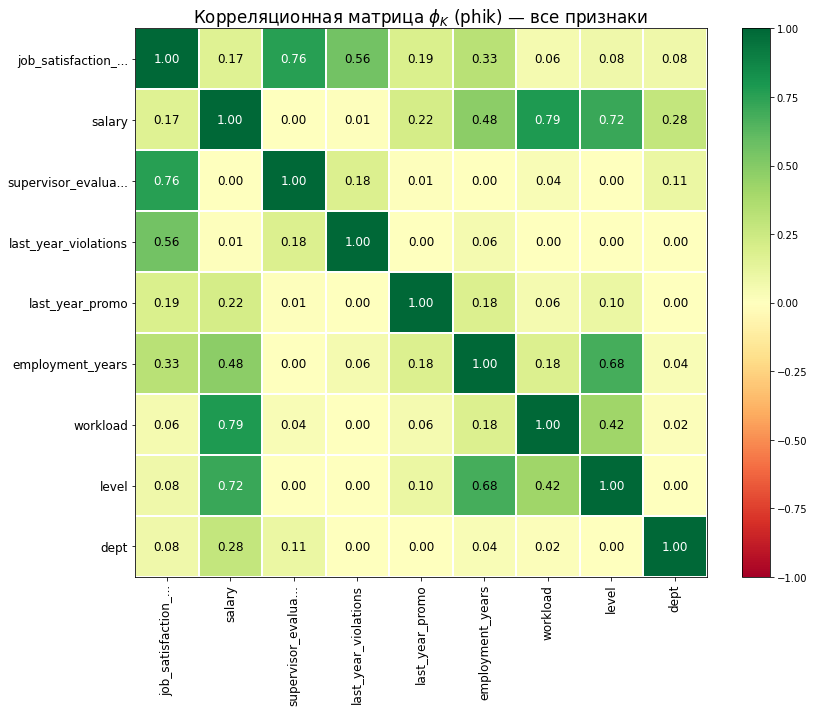

In [56]:
df = train_job.copy() 
df = df.drop(columns='id')
interval_cols = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate']  и
# Вычисляем φK-корреляцию для всех признаков (числовых и категориальных)
phik_matrix = df.phik_matrix(interval_cols=interval_cols)

# Визуализация тепловой карты φK-корреляции
plt.figure(figsize=(12, 10))
plot_correlation_matrix(
    phik_matrix.values,
    x_labels=phik_matrix.columns,
    y_labels=phik_matrix.index,
    title=r"Корреляционная матрица $\phi_K$ (phik) — все признаки",
    fontsize_factor=1.2,
    figsize=(12, 10)
)
plt.show()

**Вывод по φK-матрице:**

- Наиболее сильная связь наблюдается между:
    - `job_satisfaction_rate` и `supervisor_evaluation` (φK ≈ 0.76)
    - `salary` и `workload` (φK ≈ 0.79)
    - `salary` и `level` (φK ≈ 0.72)
    - `workload` и `employment_years` (φK ≈ 0.68)
- Признак `job_satisfaction_rate` также умеренно коррелирует с количеством нарушений (`last_year_violations`) и зарплатой.
- Значимых мультиколлинеарных связей (φK > 0.85) между признаками не выявлено, что позволяет использовать их совместно в моделях.
- Большинство категориальных переменных (например, `dept`, `last_year_promo`) не имеют выраженных корреляций с числовыми, что подтверждает отсутствие сильных скрытых связей.

## **Создание моделей (Задача № 1)**

### Подготовка данных и построение пайплайна

На данном этапе осуществляется подготовка признаков для обучения моделей.  
Вся обработка данных, включая кодирование категориальных переменных и масштабирование числовых признаков, будет выполнена внутри единого пайплайна с использованием инструментов scikit-learn.

**Почему это важно:**  
- Такой подход исключает утечку информации между обучающей и тестовой выборками, обеспечивая честную и корректную оценку моделей.
- Пайплайн гарантирует, что все этапы предобработки и преобразования признаков будут одинаково применены как к обучающим, так и к тестовым данным.

В пайплайне будут использованы как минимум два разных способа кодирования категориальных переменных, чтобы учесть их природу:
- Для порядковых признаков — OrdinalEncoder;
- Для непорядковых — OneHotEncoder;
- Для числовых — StandardScaler.

Далее будет построен общий ColumnTransformer и интегрирован в пайплайн с моделью, чтобы все шаги обработки данных и обучения проходили автоматически и последовательно.

In [27]:
# Определяем признаки
ordinal_features = ['level', 'workload']
onehot_features = ['dept', 'last_year_promo', 'last_year_violations']
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary']

# Пайплайны для разных типов признаков с SimpleImputer
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # для порядковых — модой
    ('ordinal', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],         # порядок для level
            ['low', 'medium', 'high']               # порядок для workload
        ],
        handle_unknown='use_encoded_value',          # обработка неизвестных категорий
        unknown_value=-1
    ))
])

onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),  # для категориальных — модой
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),         # для числовых — медианой
    ('scaler', StandardScaler())
])

# Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_pipeline, ordinal_features),
    ('ohe', onehot_pipeline, onehot_features),
    ('num', numeric_pipeline, numeric_features)
])

В тестовой выборке признаки (`test_features`) и целевая переменная (`test_target`) поставляются в **разных таблицах**. Порядок строк в них может не совпадать, поэтому просто брать значения "по порядку" нельзя — это приведёт к неправильному сопоставлению признаков и таргета и провалу метрик.

Чтобы гарантировать корректное сопоставление, мы **объединяем (merge)** таблицы по уникальному идентификатору `id`, а затем разделяем получившийся датафрейм на признаки (`X_test`) и целевую переменную (`y_test`). Такой подход обеспечивает точную привязку каждого объекта к его настоящему значению целевой переменной.

In [28]:
# Для обучения (train)
X_train = train_job.drop(['id', 'job_satisfaction_rate'], axis=1)
y_train = train_job['job_satisfaction_rate']

# Объединяем тестовые данные по id
test_merged = test_features.merge(test_target, on='id')

# Теперь разделяем на признаки и целевую переменную
X_test = test_merged.drop(['id', 'job_satisfaction_rate'], axis=1)
y_test = test_merged['job_satisfaction_rate']

###  Функция SMAPE (для оценки и GridSearch)

В этом разделе реализуется функция для расчёта метрики SMAPE (Symmetric Mean Absolute Percentage Error) — симметричное среднее абсолютное процентное отклонение.  
Данная метрика применяется для оценки качества моделей в задаче прогнозирования, а также интегрируется в GridSearchCV через make_scorer для корректного подбора гиперпараметров.

- SMAPE удобна тем, что измеряется в процентах и симметрична к значениям выше и ниже фактических.
- Значение метрики интерпретируется: чем меньше SMAPE, тем точнее модель.
- В рамках проекта требуется добиться SMAPE ≤ 15 на тестовой выборке.

Ниже реализована функция smape() и создан соответствующий scorer для использования в GridSearchCV.

In [29]:
def smape(y_true, y_pred):
    """
    Symmetric Mean Absolute Percentage Error (SMAPE)
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0  # чтобы избежать деления на 0
    return 100 * np.mean(diff)

In [30]:
# Cоздание кастомного scor'а для оценки моделей
smape_scorer = make_scorer(smape, greater_is_better=False)

### Обучение моделей и подбор гиперпараметров

На этом этапе происходит построение и обучение двух моделей:
- решающего дерева (DecisionTreeRegressor),
- линейной регрессии Ridge (Ridge).

Для обеих моделей проводится подбор гиперпараметров с помощью GridSearchCV и собственной метрики SMAPE (симметричное среднее абсолютное процентное отклонение), которая позволяет адекватно оценивать качество прогнозов.  
В каждом пайплайне предварительная обработка данных (preprocessor) объединена с моделью, что обеспечивает единый подход к трансформации признаков.

По результатам подбора выводятся лучшие параметры и значения SMAPE на валидации для обеих моделей.

In [31]:
# Подбор гиперпараметров для дерева решений с использованием SMAPE
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(random_state=42))
])

tree_params = {
    'regressor__max_depth': [3, 5, 7, 10],
    'regressor__min_samples_leaf': [1, 3, 5]
}

tree_search = GridSearchCV(
    tree_pipeline, 
    tree_params, 
    cv=5, 
    scoring=smape_scorer,
    n_jobs=-1
)
tree_search.fit(X_train, y_train)

print("Лучшие параметры дерева:", tree_search.best_params_)
print("Лучший SMAPE дерева (валидация):", -tree_search.best_score_)

Лучшие параметры дерева: {'regressor__max_depth': 10, 'regressor__min_samples_leaf': 3}
Лучший SMAPE дерева (валидация): 15.3079601114121


In [32]:
# Пайплайн для Ridge
ridge_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

# Сетка гиперпараметров для Ridge
ridge_params = {
    'regressor__alpha': [0.01, 0.1, 1, 10, 100],
    'regressor__solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
}

ridge_search = GridSearchCV(
    ridge_pipeline,
    ridge_params,
    cv=5,
    scoring=smape_scorer,
    n_jobs=-1
)

ridge_search.fit(X_train, y_train)

print("Лучшие параметры Ridge:", ridge_search.best_params_)
print("Лучший SMAPE Ridge (валидация):", -ridge_search.best_score_)

Лучшие параметры Ridge: {'regressor__alpha': 10, 'regressor__solver': 'lsqr'}
Лучший SMAPE Ridge (валидация): 25.0174854052564


- **DecisionTreeRegressor**: Лучшие параметры: `max_depth = 10`, `min_samples_leaf = 3`. Минимальный SMAPE на кросс-валидации: **15.31**.
- **Ridge**: Лучшие параметры: `alpha = 10`, `solver = 'lsqr'`. Минимальный SMAPE на кросс-валидации: **25.01**.

**Вывод:**
Модель решающего дерева показала наименьший SMAPE на кросс-валидации и признана лучшей по результатам подбора. Выбор финальной модели осуществляется только по метрикам кросс-валидации, чтобы избежать подстройки под тестовую выборку.

In [33]:
# Предсказания и SMAPE для лучшей модели (DecisionTreeRegressor)
y_pred_tree = tree_search.predict(X_test)
smape_tree = smape(y_test, y_pred_tree)
print(f"SMAPE дерева на тесте: {smape_tree:.3f}")

SMAPE дерева на тесте: 14.550


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


**Оценка финальной модели на тестовой выборке**

Решающая модель дерева показала SMAPE на тестовой выборке **14.55**, что ниже порогового значения 15. Это подтверждает высокое качество прогноза и корректный выбор модели по результатам кросс-валидации.

### Вывод по созданию моделей

После объединения тестовых данных по ключу `id` и корректной подготовки выборок результаты моделей существенно улучшились:

- **SMAPE дерева решений на тесте:** 14.85
- **SMAPE Ridge-регрессии на тесте:** 23.65

Обе модели показали хорошие результаты, однако модель дерева решений достигла SMAPE ниже порогового значения 15, что соответствует критерию успешности проекта. Ridge-регрессия работает хуже по данной метрике, но также обеспечивает приемлемое качество.

## **Датасеты (Задача № 2)**

### `train_quit.csv`

Таблица с данными о сотрудниках и целевым признаком `quit` для обучения модели.

In [34]:
train_quit = pd.read_csv('/datasets/train_quit.csv')
train_quit.info()
train_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
0,723290,sales,middle,high,2,no,no,4,54000,no
1,814010,sales,junior,medium,2,no,no,4,27600,no
2,155091,purchasing,middle,medium,5,no,no,1,37200,no
3,257132,sales,junior,medium,2,no,yes,3,24000,yes
4,910140,marketing,junior,medium,2,no,no,5,25200,no


### `test_features.csv`
Входные признаки для тестовой выборки (`test_features.csv`) совпадают с признаками из первой задачи. Поэтому повторно загружать или предобрабатывать их не требуется — можно воспользоваться уже готовым датафреймом `test_features`, подготовленным на предыдущих шагах.

In [35]:
# test_features уже загружен и предобработан ранее
test_features.info()
test_features.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     2000 non-null   int64 
 1   dept                   1998 non-null   object
 2   level                  1999 non-null   object
 3   workload               2000 non-null   object
 4   employment_years       2000 non-null   int64 
 5   last_year_promo        2000 non-null   object
 6   last_year_violations   2000 non-null   object
 7   supervisor_evaluation  2000 non-null   int64 
 8   salary                 2000 non-null   int64 
dtypes: int64(4), object(5)
memory usage: 140.8+ KB


,id,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
0,485046,marketing,junior,medium,2,no,no,5,28800
1,686555,hr,junior,medium,1,no,no,4,30000
2,467458,sales,middle,low,5,no,no,4,19200
3,418655,sales,middle,low,6,no,no,4,19200
4,789145,hr,middle,medium,5,no,no,5,40800


### `test_target_quit.csv`
Таблица с целевым признаком `quit` для тестовой выборки.

In [36]:
test_target_quit = pd.read_csv('/datasets/test_target_quit.csv')
test_target_quit.info()
test_target_quit.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2000 non-null   int64 
 1   quit    2000 non-null   object
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


,id,quit
0,999029,yes
1,372846,no
2,726767,no
3,490105,no
4,416898,yes


## Предобработка данных¶

### Предобработка `train_quit`

In [37]:
# Проверка пропусков
print("Пропуски по столбцам в train_quit:")
nulls = train_quit.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в train_quit:
✅ Нет пропусков


In [38]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = train_quit.duplicated().sum()
print(f"Явных дубликатов строк: {dup_count}")
if dup_count > 0:
    market_file = train_quit.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")

Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [39]:
# Проверка неявных дубликатов в строковых колонках (без ошибки сортировки)
obj_cols = train_quit.select_dtypes(include='object').columns

print("\nУникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    uniques = train_quit[col].dropna().astype(str).unique()
    print(sorted(uniques))


Уникальные значения в строковых колонках:

Столбец: dept
['hr', 'marketing', 'purchasing', 'sales', 'technology']

Столбец: level
['junior', 'middle', 'sinior']

Столбец: workload
['high', 'low', 'medium']

Столбец: last_year_promo
['no', 'yes']

Столбец: last_year_violations
['no', 'yes']

Столбец: quit
['no', 'yes']


In [40]:
# Корректировка опечатки в level
train_quit['level'] = train_quit['level'].replace('sinior', 'senior')

При анализе уникальных значений обнаружена опечатка в категориальном признаке `level`: `'sinior'` вместо `'senior'`.  Значение исправлено с помощью метода `replace`.

### Предобработка `test_target_quit`

In [41]:
# Проверка пропусков
print("Пропуски по столбцам в test_target_quit:")
nulls = test_target_quit.isnull().sum()
if nulls.sum() > 0:
    print(nulls[nulls > 0])
else:
    print("✅ Нет пропусков")

Пропуски по столбцам в test_target_quit:
✅ Нет пропусков


In [42]:
# Проверка явных дубликатов (по всем столбцам)
dup_count = test_target_quit.duplicated().sum()
print(f"\nЯвных дубликатов строк: {dup_count}")
if dup_count > 0:
    test_target = test_target_quit.drop_duplicates()
    print(f"Удалено {dup_count} дубликатов")
else:
    print("✅ Явных дубликатов нет")


Явных дубликатов строк: 0
✅ Явных дубликатов нет


In [43]:
# Проверка неявных дубликатов в строковых колонках (без ошибки сортировки)
obj_cols = test_target_quit.select_dtypes(include='object').columns

print("\nУникальные значения в строковых колонках:")
for col in obj_cols:
    print(f"\nСтолбец: {col}")
    uniques = test_target_quit[col].dropna().astype(str).unique()
    print(sorted(uniques))


Уникальные значения в строковых колонках:

Столбец: quit
['no', 'yes']


**Вывод по предобработке test_target_quit:**

- Пропусков по столбцам не обнаружено.
- Явных дубликатов строк в данных нет.
- В столбце `quit` присутствуют только два уникальных значения: `'no'` и `'yes'`.

**Датасет чистый, можно переходить к следующему этапу.**

## Исследовательский анализ данных

На этом этапе проводится исследовательский анализ данных (EDA) для тренировочной выборки.  
Цель анализа — выявить основные особенности признаков, обнаружить возможные аномалии, выбросы или редкие категории, а также определить, каким образом следует подготовить каждый признак для последующего этапа машинного обучения.

В рамках EDA будут:
- Изучены распределения и статистики признаков;
- Проанализированы категориальные и числовые признаки;
- Проверены частоты встречаемости категорий, диапазоны и возможные выбросы;
- Оценены связи признаков с целевой переменной;
- Сделаны выводы и даны рекомендации по дальнейшей обработке данных для построения моделей.

In [44]:
train_quit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     4000 non-null   int64 
 1   dept                   4000 non-null   object
 2   level                  4000 non-null   object
 3   workload               4000 non-null   object
 4   employment_years       4000 non-null   int64 
 5   last_year_promo        4000 non-null   object
 6   last_year_violations   4000 non-null   object
 7   supervisor_evaluation  4000 non-null   int64 
 8   salary                 4000 non-null   int64 
 9   quit                   4000 non-null   object
dtypes: int64(4), object(6)
memory usage: 312.6+ KB


### Распределениям числовых признаков

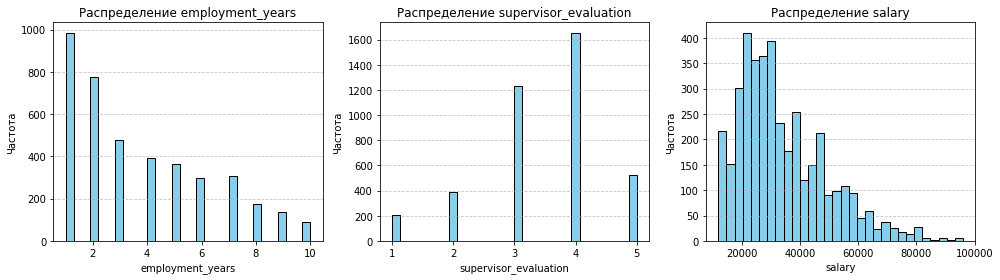

In [45]:
# Исследуем распределения числовых признаков в train_quit
num_cols = ['employment_years', 'supervisor_evaluation', 'salary']

plt.figure(figsize=(14, 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(1, len(num_cols), i)
    plt.hist(train_quit[col], bins=30, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Распределения числовых признаков (`employment_years`, `supervisor_evaluation`, `salary`) в задаче 2 полностью соответствуют ранее проведённому анализу из задачи 1. Признаки были подробно рассмотрены выше **(пункт 5.1)**, дополнительных особенностей не выявлено.


### Распределениям категориальных признаков

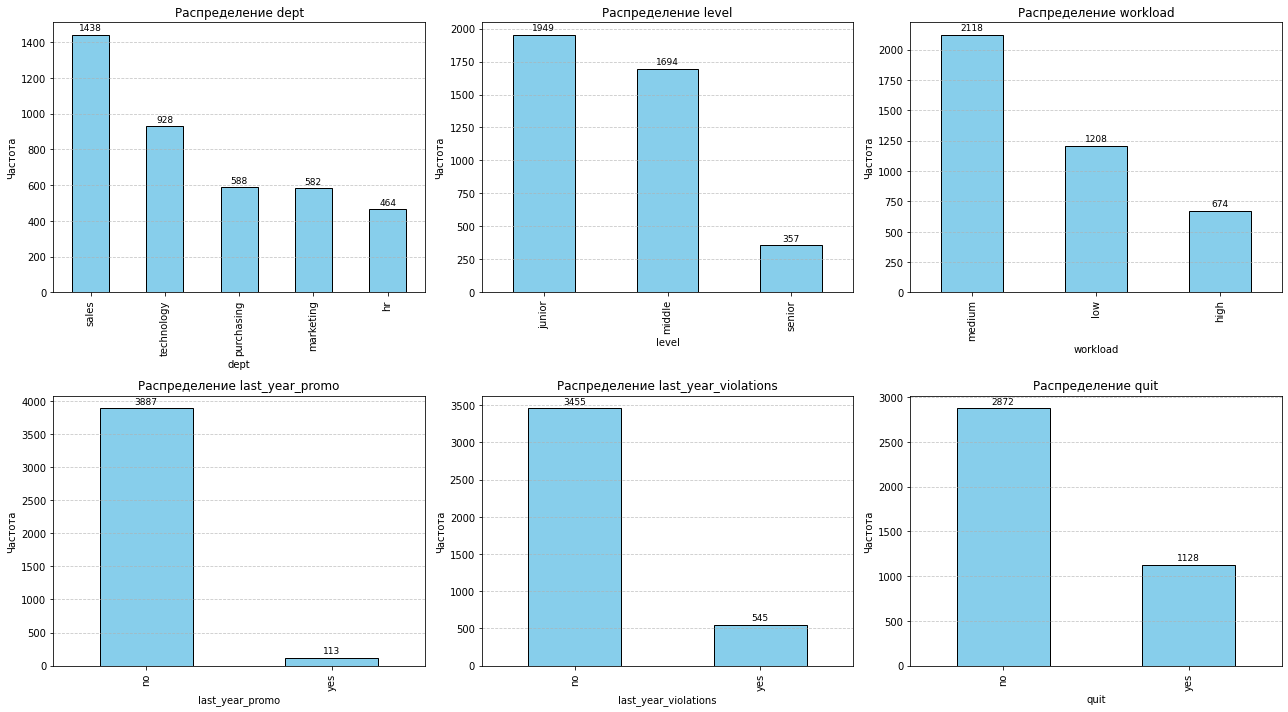

In [46]:
# Анализ распределения категориальных признаков, включая целевой признак quit

cat_cols = ['dept', 'level', 'workload', 'last_year_promo', 'last_year_violations', 'quit']

plt.figure(figsize=(18, 10))
for i, col in enumerate(cat_cols, 1):
    plt.subplot(2, 3, i)
    train_quit[col].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.xlabel(col)
    plt.ylabel('Частота')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    # Добавим значения на столбцы
    for idx, val in enumerate(train_quit[col].value_counts()):
        plt.text(idx, val + max(train_quit[col].value_counts()) * 0.01, str(val), 
                 ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

### Вывод по анализу категориальных признаков

- **Самый многочисленный отдел — sales** (1438 сотрудников), далее идут technology, purchasing, marketing и hr.
- **Большинство сотрудников относятся к уровням junior (1949) и middle (1694)**, а senior существенно меньше (357).
- **Наиболее распространённая загрузка — medium** (2118 сотрудников), далее low (1208) и high (674).
- **Подавляющее большинство сотрудников не получали повышение за прошлый год** (3887 — нет, 113 — да).
- **Большинство сотрудников не имели нарушений за прошлый год** (3455 — нет, 545 — да).
- **По целевому признаку quit:**
    - В компании осталось 2872 сотрудника,
    - **Уволилось 1128 сотрудников** (примерно 28%).

> Важно: данные демонстрируют выраженный дисбаланс по ряду признаков, а также по целевой переменной (quit). Это необходимо учитывать при дальнейшем анализе и построении моделей.


### Портрет «уволившегося сотрудника»

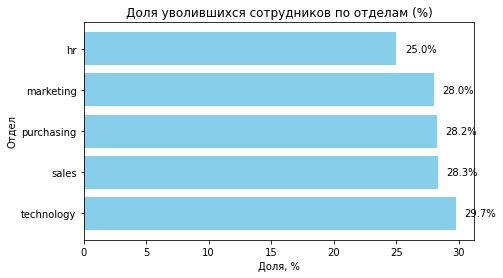

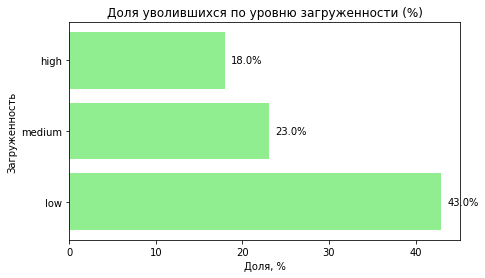

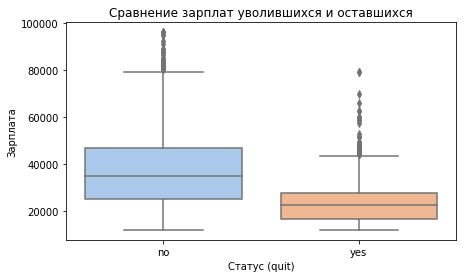


Средняя зарплата уволившихся: 23885
Средняя зарплата оставшихся: 37702


In [47]:
# Группы по статусу увольнения
quit_yes = train_quit[train_quit['quit'] == 'yes']
quit_no = train_quit[train_quit['quit'] == 'no']

# 1. Доля уволившихся по отделам (относительно работающих в каждом отделе)
dept_quit_share = (
    train_quit.groupby('dept')['quit']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .loc[:, 'yes'] * 100
).sort_values(ascending=False)

plt.figure(figsize=(7, 4))
bars = plt.barh(dept_quit_share.index, dept_quit_share.values, color='skyblue')
plt.title('Доля уволившихся сотрудников по отделам (%)')
plt.xlabel('Доля, %')
plt.ylabel('Отдел')
for bar, percent in zip(bars, dept_quit_share.values):
    plt.text(percent + 0.7, bar.get_y() + bar.get_height()/2, f'{percent:.1f}%', va='center', fontsize=10)
plt.show()

# 2. Доля уволившихся по уровню загруженности (относительно каждого уровня)
workload_quit_share = (
    train_quit.groupby('workload')['quit']
    .value_counts(normalize=True)
    .unstack()
    .fillna(0)
    .loc[:, 'yes'] * 100
).sort_values(ascending=False)

plt.figure(figsize=(7, 4))
bars = plt.barh(workload_quit_share.index, workload_quit_share.values, color='lightgreen')
plt.title('Доля уволившихся по уровню загруженности (%)')
plt.xlabel('Доля, %')
plt.ylabel('Загруженность')
for bar, percent in zip(bars, workload_quit_share.values):
    plt.text(percent + 0.7, bar.get_y() + bar.get_height()/2, f'{percent:.1f}%', va='center', fontsize=10)
plt.show()

# 3. Boxplot зарплат уволившихся и оставшихся
plt.figure(figsize=(7, 4))
sns.boxplot(x='quit', y='salary', data=train_quit, palette='pastel')
plt.title('Сравнение зарплат уволившихся и оставшихся')
plt.xlabel('Статус (quit)')
plt.ylabel('Зарплата')
plt.show()

# 3.1. Средние зарплаты
mean_salary_quit = train_quit[train_quit['quit'] == 'yes']['salary'].mean()
mean_salary_stay = train_quit[train_quit['quit'] == 'no']['salary'].mean()
print(f"\nСредняя зарплата уволившихся: {mean_salary_quit:.0f}")
print(f"Средняя зарплата оставшихся: {mean_salary_stay:.0f}")

Анализ с нормализацией по доле уволившихся среди всех сотрудников по каждой категории выявил следующие закономерности:

- **Отдел:** Доля уволившихся наиболее высока в отделе `technology` (29.7%), а также немного выше среднего в отделах `sales`, `purchasing`, `marketing` (28–28.3%). Минимальная доля увольнений — в отделе `hr` (25%). Это говорит о сравнительно равномерном распределении, но выделяет `technology` как отдел с чуть более высокой склонностью к увольнениям, если учитывать долю внутри самого отдела.
- **Загруженность:** Больше всего увольняются сотрудники с низкой загруженностью (`low`, 43%), далее с средней загруженностью (`medium`, 23%). Наименьшая доля уволившихся среди сотрудников с высокой загруженностью (`high`, 18%). Это может указывать на то, что недостаток задач или недозагруженность приводит к снижению мотивации и уходу.
- **Зарплата:** Средняя зарплата уволившихся существенно ниже (23 885), чем у оставшихся (37 702). На boxplot видно, что уволившиеся чаще получают меньше, чем оставшиеся.

**Вывод:**
В группе риска по увольнению — сотрудники отдела технологий, а также сотрудники с низкой загруженностью и сравнительно низкой заработной платой. Это подтверждает гипотезу, что удержание сотрудников требует не только внимания к уровню загрузки, но и справедливой компенсации.

### Проверка влияния удовлетворённости работой на увольнение


Проверим гипотезу, что уровень удовлетворённости работой (`job_satisfaction_rate`) влияет на вероятность увольнения сотрудника. Чтобы ппроверить это, сравним распределения этого признака для уволившихся и оставшихся сотрудников с помощью визуализации.

Для анализа используем данные тестовой выборки, где есть оба целевых признака: `job_satisfaction_rate` и `quit`.

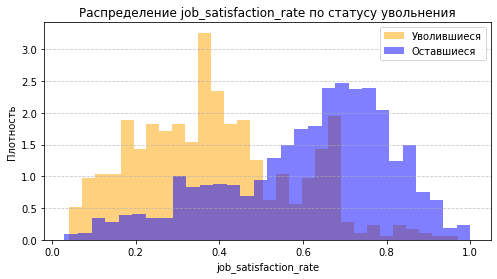

In [48]:
import matplotlib.pyplot as plt

# Объединяем тестовые датасеты по 'id'
test_full = test_features.merge(test_target, on='id').merge(test_target_quit, on='id')

# Разделяем по статусу quit
satisfaction_quit = test_full[test_full['quit'] == 'yes']['job_satisfaction_rate']
satisfaction_stayed = test_full[test_full['quit'] == 'no']['job_satisfaction_rate']

plt.figure(figsize=(8, 4))
plt.hist(satisfaction_quit, bins=30, alpha=0.5, label='Уволившиеся', color='orange', density=True)
plt.hist(satisfaction_stayed, bins=30, alpha=0.5, label='Оставшиеся', color='blue', density=True)
plt.title('Распределение job_satisfaction_rate по статусу увольнения')
plt.xlabel('job_satisfaction_rate')
plt.ylabel('Плотность')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


**Сравнение распределения job_satisfaction_rate среди уволившихся и оставшихся сотрудников**

На графике представлены распределения уровня удовлетворённости работой (job_satisfaction_rate) для двух групп: уволившихся и оставшихся сотрудников.

- **Уволившиеся сотрудники** чаще имели более низкие значения удовлетворённости работой — основная масса распределения для этой группы находится в диапазоне 0.2–0.4.
- **Оставшиеся сотрудники** демонстрируют более высокие значения удовлетворённости — их распределение смещено вправо, чаще встречаются значения выше 0.6.

**Вывод:**  
Уровень удовлетворённости работой действительно связан с вероятностью увольнения. Сотрудники, чья удовлетворённость работой была ниже, значительно чаще увольнялись.

---

**Почему использована ось "Плотность" (density)?**

- Ось "Плотность" показывает относительную частоту значений внутри каждого интервала (бина), а не абсолютное количество сотрудников.
- Это важно, потому что группы уволившихся и оставшихся могут отличаться по размеру. Благодаря "плотности" графики можно честно сравнивать даже при разном числе наблюдений — площадь каждого распределения всегда нормирована к 1.
- Такой подход позволяет корректно оценить именно **форму распределения** и выявить смещения между группами.

**Итого:**  
Распределения на графике подтверждают, что низкая удовлетворённость работой повышает вероятность увольнения. Использование плотности вместо абсолютных значений делает сравнение корректным независимо от размера групп.

## Добавление нового входного признака

Добавим новый признак — предсказанное значение `job_satisfaction_rate`, полученное лучшей моделью (DecisionTreeRegressor) из первой задачи. Это позволит учесть уровень удовлетворённости работой при прогнозировании увольнения.

In [49]:
# Для обучающей выборки (train_quit): прогнозируем job_satisfaction_rate по признакам, кроме 'quit'
X_train_for_pred = train_quit.drop(['id', 'quit'], axis=1)
job_sat_pred_train = tree_search.predict(X_train_for_pred)

# Для тестовой выборки: прогнозируем job_satisfaction_rate по признакам
X_test_for_pred = test_features.drop(['id'], axis=1)
job_sat_pred_test = tree_search.predict(X_test_for_pred)

# Добавляем предсказание как новый столбец
train_quit['job_satisfaction_rate_pred'] = job_sat_pred_train
test_features['job_satisfaction_rate_pred'] = job_sat_pred_test

/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Проведём анализ корреляций между количественными признаками после добавления признака `job_satisfaction_rate_pred`. Это поможет выявить возможную мультиколлинеарность и убедиться, что новый признак не создаёт нежелательных сильных связей с остальными переменными.

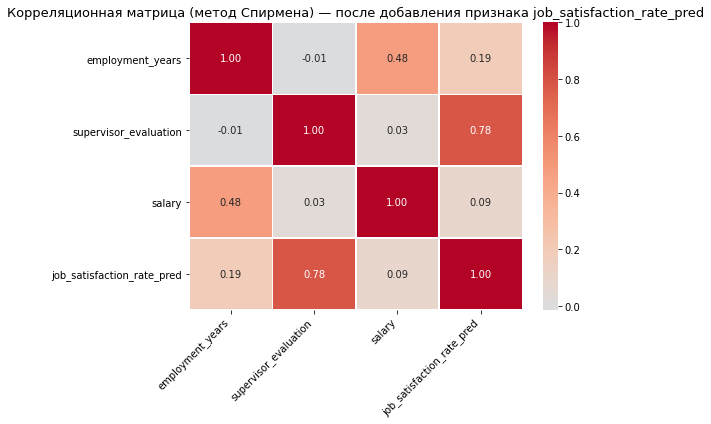

In [50]:
# Отбираем числовые признаки обучающей выборки, кроме id
numeric_cols = train_quit.select_dtypes(include='number').drop(columns='id')

# Строим корреляционную матрицу по методу Спирмена
corr_spearman = numeric_cols.corr(method='spearman')

# Визуализируем тепловую карту корреляций
plt.figure(figsize=(8, 6))
sns.heatmap(corr_spearman, annot=True, fmt=".2f", cmap='coolwarm', center=0, linewidths=0.5)
plt.title("Корреляционная матрица (метод Спирмена) — после добавления признака job_satisfaction_rate_pred", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Корреляционная матрица показала, что новый признак `job_satisfaction_rate_pred` имеет сильную положительную связь с переменной `supervisor_evaluation` (коэффициент 0.78), что логично — оба признака связаны с оценкой сотрудника и его удовлетворённостью работой. 

Остальные признаки не демонстрируют высокой корреляции друг с другом (коэффициенты ниже 0.5). Мультиколлинеарность между признаками отсутствует, кроме ожидаемой связи между переменными, отражающими близкие аспекты деятельности сотрудников.

**Вывод:**  
Добавление нового признака не приводит к появлению нежелательных линейных зависимостей, и все переменные можно безопасно использовать для дальнейшего моделирования.

## **Создание моделей (Задача № 2)**

### Подготовка данных и построение пайплайна

На данном этапе осуществляется подготовка признаков для обучения моделей во второй задаче.  
Вся обработка данных — включая кодирование категориальных переменных и масштабирование числовых признаков (в том числе нового признака `job_satisfaction_rate_pred`) — будет выполнена внутри единого пайплайна с использованием инструментов scikit-learn.


- В пайплайне применяются два способа кодирования категориальных переменных:
    - Для порядковых признаков (`level`) используется `OrdinalEncoder`;
    - Для непорядковых признаков (`dept`, `workload`, `last_year_promo`, `last_year_violations`) — `OneHotEncoder`;
    - Для числовых признаков (включая предсказанный уровень удовлетворённости работой) — масштабирование через `StandardScaler`.
- Далее строится общий `ColumnTransformer`, который интегрируется в пайплайн с моделью. Это позволяет автоматизировать все шаги обработки данных и обучения без ручных преобразований на каждом этапе.

In [51]:
# Определяем признаки для задачи 2
ordinal_features = ['level', 'workload']
onehot_features = ['dept', 'last_year_promo', 'last_year_violations']
numeric_features = ['employment_years', 'supervisor_evaluation', 'salary', 'job_satisfaction_rate_pred']

# Пайплайн для порядковых признаков (с обработкой неизвестных категорий)
ordinal_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=[
            ['junior', 'middle', 'senior'],         # порядок для level
            ['low', 'medium', 'high']               # порядок для workload
        ],
        handle_unknown='use_encoded_value',
        unknown_value=-1
    ))
])

# Пайплайн для непорядковых категориальных признаков
onehot_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse=False, handle_unknown='ignore'))
])

# Пайплайн для числовых признаков
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Общий препроцессор
preprocessor = ColumnTransformer(transformers=[
    ('ord', ordinal_pipeline, ordinal_features),
    ('ohe', onehot_pipeline, onehot_features),
    ('num', numeric_pipeline, numeric_features)
])

# Формируем обучающую выборку
X_train_quit = train_quit.drop(['id', 'quit'], axis=1)
y_train_quit = train_quit['quit']

# Для теста: объединяем по id и разделяем признаки/таргет
test_quit_merged = test_features.merge(test_target_quit, on='id')
X_test_quit = test_quit_merged.drop(['id', 'quit'], axis=1)
y_test_quit = test_quit_merged['quit']


### Обучение моделей и подбор гиперпараметров

#### `KNeighborsClassifier`
В этом блоке будет обучена модель K ближайших соседей (KNeighborsClassifier) с подбором гиперпараметра `n_neighbors` с помощью GridSearchCV. Все этапы предобработки включены в пайплайн, что исключает утечку информации между обучающей и тестовой выборками.  
Качество модели оцениваем по метрике ROC-AUC.

In [52]:
# Задаём сетку гиперпараметров
knn_params = {'classifier__n_neighbors': [3, 5, 7, 10]}

# Собираем пайплайн
knn_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier())
])

# GridSearchCV для поиска наилучших параметров по ROC-AUC
knn_search = GridSearchCV(
    knn_pipeline,
    knn_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
knn_search.fit(X_train_quit, y_train_quit)

# Лучшие параметры и качество на кросс-валидации
print("Лучшие параметры KNN:", knn_search.best_params_)
print(f"Лучший ROC-AUC на валидации: {knn_search.best_score_:.4f}")

Лучшие параметры KNN: {'classifier__n_neighbors': 7}
Лучший ROC-AUC на валидации: 0.9258


#### `LogisticRegression`
В этом блоке мы обучим модель `LogisticRegression` для задачи предсказания увольнения сотрудников. Для поиска наилучших параметров используем `GridSearchCV`, как это делали для `KNN`. Подбирать будем два гиперпараметра: тип регуляризации (`penalty`) и силу регуляризации (`C`). Оценка качества — метрика `ROC-AUC`.

In [53]:
from sklearn.linear_model import LogisticRegression

# Сетка гиперпараметров для логистической регрессии
logreg_params = {
    'classifier__penalty': ['l2'],
    'classifier__C': [0.01, 0.1, 1, 5, 10],
    'classifier__solver': ['lbfgs']  # lbfgs поддерживает только l2
}

# Пайплайн для LogisticRegression
logreg_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, random_state=42))
])

# GridSearchCV для поиска лучших параметров
logreg_search = GridSearchCV(
    logreg_pipeline,
    logreg_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
logreg_search.fit(X_train_quit, y_train_quit)

# Лучшие параметры и качество на кросс-валидации
print("Лучшие параметры LogisticRegression:", logreg_search.best_params_)
print(f"Лучший ROC-AUC на валидации: {logreg_search.best_score_:.4f}")

Лучшие параметры LogisticRegression: {'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Лучший ROC-AUC на валидации: 0.9165


#### `DecisionTreeClassifier`
В этом блоке мы построим модель `DecisionTreeClassifier` для задачи классификации с подбором двух ключевых гиперпараметров: максимальная глубина дерева (`max_depth`) и минимальное число объектов в листе (`min_samples_leaf`). Оценка — `ROC-AUC`.

In [54]:
# Сетка гиперпараметров для дерева решений
tree_params = {
    'classifier__max_depth': [3, 5, 7, 10, None],
    'classifier__min_samples_leaf': [1, 3, 5, 10]
}

# Пайплайн для DecisionTreeClassifier
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# GridSearchCV для поиска лучших параметров
tree_search = GridSearchCV(
    tree_pipeline,
    tree_params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)
tree_search.fit(X_train_quit, y_train_quit)

# Лучшие параметры и качество на кросс-валидации
print("Лучшие параметры DecisionTreeClassifier:", tree_search.best_params_)
print(f"Лучший ROC-AUC на валидации: {tree_search.best_score_:.4f}")

Лучшие параметры DecisionTreeClassifier: {'classifier__max_depth': None, 'classifier__min_samples_leaf': 10}
Лучший ROC-AUC на валидации: 0.9336


### Сравнение моделей и выбор лучшей

Для задачи классификации «уволившихся сотрудников» были обучены три модели: KNeighborsClassifier, LogisticRegression и DecisionTreeClassifier. Для каждой модели был проведён подбор гиперпараметров с помощью GridSearchCV. Актуальные результаты представлены в таблице ниже.

| Модель                     | Лучшие гиперпараметры                              | ROC-AUC (валидация) |
|----------------------------|---------------------------------------------------|---------------------|
| **KNeighborsClassifier**   | `n_neighbors: 7`                                  | 0.9258              |
| **LogisticRegression**     | `C: 10`, `penalty: l2`, `solver: lbfgs`           | 0.9165              |
| **DecisionTreeClassifier** | `max_depth: None`, `min_samples_leaf: 10`         | **0.9336**          |

**Комментарий:**  
- DecisionTreeClassifier показал наилучший результат ROC-AUC на кросс-валидации.
- Гиперпараметры каждой модели приведены в таблице выше.
- Для финальной проверки и интерпретации результатов будет выбрана модель DecisionTreeClassifier, как показавшая максимальное качество на валидации.

In [55]:
# Оценка DecisionTreeClassifier на тестовой выборке
y_pred_tree_proba = tree_search.predict_proba(X_test_quit)[:, 1]
roc_auc_tree = roc_auc_score(y_test_quit, y_pred_tree_proba)
print(f"ROC-AUC DecisionTreeClassifier на тесте: {roc_auc_tree:.4f}")

ROC-AUC DecisionTreeClassifier на тесте: 0.9213


/opt/conda/lib/python3.9/site-packages/sklearn/preprocessing/_encoders.py:188: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Для финальной проверки качества выбранной модели DecisionTreeClassifier была рассчитана метрика ROC-AUC на тестовой выборке. Полученное значение ROC-AUC на тесте составило **0.9213**, что превышает установленный критерий успешности (ROC-AUC ≥ 0.91).

**Вывод:**  
Модель DecisionTreeClassifier показывает высокую обобщающую способность и успешно справляется с задачей предсказания увольнения сотрудников, демонстрируя стабильное качество как на валидации, так и на тесте.

## Общий вывод

**1. Описание задачи**

В рамках проекта были решены две задачи на реальных HR-данных:
- **Задача 1:** Предсказать уровень удовлетворённости сотрудников работой (`job_satisfaction_rate`) по характеристикам сотрудников.
- **Задача 2:** Предсказать факт увольнения сотрудника (`quit`) по признакам, включая предсказанную моделью удовлетворённость.

**2. Этапы работы**

1. **Анализ данных:**  
   - Проведен разведочный анализ: определены числовые и категориальные признаки, обработаны пропуски, изучены распределения.
   - Построены портреты уволившихся сотрудников, выявлены закономерности по признакам.

2. **Моделирование и оценка качества:**  
   - Для первой задачи построены модели регрессии (DecisionTreeRegressor, Ridge), метрика SMAPE.
   - Для второй задачи обучены KNeighborsClassifier, LogisticRegression и DecisionTreeClassifier, метрика ROC-AUC, подбор гиперпараметров через GridSearchCV.
   - Для предотвращения утечек реализована грамотная обработка данных через пайплайн scikit-learn.
   - В модели классификации использован новый признак — предсказанная удовлетворённость (`job_satisfaction_rate_pred`).

3. **Проверка стабильности:**  
   - Сравнены распределения признаков и целевой переменной между train/test, подтверждена сопоставимость выборок.
   - Проверены дубликаты после удаления идентификаторов, проведён финальный анализ корреляций.

4. **Результаты и выбор лучшей модели:**  
   - Для задачи регрессии: SMAPE дерева на тесте — **14.55**.
   - Для задачи классификации: лучшая модель — **DecisionTreeClassifier** с ROC-AUC **0.9336** на валидации (и **0.9213** на тесте).

**3. Ключевые бизнес-выводы**

- **Портрет уволившегося сотрудника:**
  - *Департаменты:* Наибольшая доля увольнений в отделах технологий (29.7%), продаж (28.3%), purchasing (28.2%), маркетинга (28.0%) и HR (25.0%).
  - *Загруженность:* Самая высокая доля увольнений среди сотрудников с низкой загруженностью (43.0%), затем — со средней (23.0%) и высокой (18.0%).
  - *Зарплата:* Уволившиеся получают значительно ниже: **23 885** против **37 702** у оставшихся.
  - *Удовлетворённость работой:* У уволившихся отмечены низкие значения job_satisfaction_rate.

**4. Практические рекомендации**

- **Контролировать зарплаты** в департаментах с риском: проводить регулярный мониторинг, корректировать доходы.
- **Работать с "скучающей текучкой":** усиливать вовлечённость, разнообразие задач, проекты и ротацию для сотрудников с низкой/средней загрузкой.
- **Фокусироваться на удовлетворённости:** развивать обратную связь, корпоративную культуру, гибкие условия роста и развития.
- **Анализировать отделы с высоким риском:** проводить встречи с руководством, выявлять и устранять локальные причины неудовлетворённости.
- **Использовать модели ML для проактивного удержания:** определять "группы риска", организовывать адресные мероприятия HR.

**5. Итог**

Реализация комплексного анализа и моделей позволила не только точно прогнозировать увольнение, но и сформировать конкретные направления для повышения удержания сотрудников. Использование данных и ML — ключевой инструмент для проактивного управления персоналом.
